In [1]:
# %pip install nglview
# %pip install ase
# %pip install pandas
# %pip install ipywidgets==7.6.5
# !jupyter-nbextension enable nglview --py --sys-prefix

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Download Transition1x dataset in NPZ format for NequIP training

In [30]:
# %git clone https://gitlab.com/matschreiner/Transition1x
# %cd Transition1x
# %pip install .
# %python download_t1x.py /data
# %pwd
# %pip list

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 2.7 MB/s eta 0:00:00a 0:00:01
  Using cached ipython_genutils-0.2.0-py2.py3-none-any.whl (26 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 19.4 MB/s eta 0:00:0000:0100:01
  Using cached fastjsonschema-2.16.3-py3-none-any.whl (23 kB)
  Using cached jsonschema-4.17.3-py3-none-any.whl (90 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 529.8/529.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 7.6 MB/s eta 0:00:00
  Using cached pyrsistent-0.19.3-cp310-cp310-macosx_10_9_universal2.whl (82 kB)
  Using cached Jinja2-3.1.2-py3-none-any.whl (133 kB)
  Using cached argon2_cffi-21.3.0-py3-none-any.whl (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.1/284.1 kB 16.1 MB/s eta 0:00:00
  Using cached Send2Trash-1.8.0-py3-none-any.whl (18 kB)
  Using cached terminado-0.17.1-py3-none-any.whl (17 kB)
  Usi

In [112]:
# import modules
import os
from transition1x import Dataloader
import numpy as np
import matplotlib.pyplot as plt
from ase import io
from ase.visualize import view
from ase import Atoms
from ase.io import write

In [113]:
# Load Transition1 training dataset from an HDF5 file using the Transition1x Dataloader class
dataloader_train = Dataloader('data/transition1x.h5', datasplit='train', only_final=True)
dataloader_test = Dataloader('data/transition1x.h5', datasplit='test', only_final=True)
dataloader_val = Dataloader('data/transition1x.h5', datasplit='val', only_final=True)

In [115]:
counts_reactant = {}
counts_product = {}
counts_transition = {}

def count_rxn(state):
    """Count the number of reactions for each chemicial formula. We will plot the reaction disitribution below to gain an overview of 
    - the number of unique molecules (chemical formula) there there in a dataset, 
    - the total number of reactions
    - and the number of reactions per molecule
    """
    formula = configurations[state]['formula']
    if state == 'reactant':
        if formula in counts_reactant:
            counts_reactant[formula] += 1
        else:
            counts_reactant[formula] = 1
    elif state == 'product':
        if formula in counts_product:
            counts_product[formula] += 1
        else:
            counts_product[formula] = 1
    elif state == 'transition_state':
        if formula in counts_transition:
            counts_transition[formula] += 1
        else:
            counts_transition[formula] = 1

# Iterate over the dataloader object
for idx, configurations in enumerate(dataloader_train):
    """The dataloader is an iterable object that returns nested dictionaries of molecular configuration for each reaction (rxn). 
    In other words, each reaction dictionary contains a unique reaction number, and the molecular configurations of a single molecule in three different conformations (reactant, product, transition_state),
    in addition to other information such as forces, energy, positions etc.. 
    Note that the chemical formula in all three configurations are the same. The Reactant, transition state and product molecule have the same chemical formula. 
    What changes are the positons, forces and energies.  
    {
        rxn: 001
        Reactant: {rxn:001, forces:, positions:, formula:}
        Product: {rxn:001, forces:, positions:, formula:}
        Transition_state: {rxn001:, forces:, positions:, formula:}
    }
    """
    # Count number of reactions per chemical formula
    # The results of all three reaction counts should be the same
    count_rxn('reactant') 
    count_rxn('product')
    count_rxn('transition_state')

    # Extract nested dictionary with information on molecular configuration, forces, positions etc.
    rxn = configurations['rxn']
    reactant = configurations['reactant']
    product = configurations['product']
    transition_state = configurations['transition_state']

    # Create directory to save xyz files
    rxn_path = os.path.join('data', rxn)
    os.makedirs(rxn_path, exist_ok=True)

    # Create ase atom objects with position and atomic numbers to render with the ase view method
    reactant = Atoms(positions=reactant['positions'], numbers = reactant['atomic_numbers'])
    product = Atoms(positions=product['positions'], numbers = product['atomic_numbers'])
    transition_state = Atoms(positions=transition_state['positions'], numbers = transition_state['atomic_numbers'])

    # Save atom objects in xyz file
    write(os.path.join(rxn_path, 'r.xyz'), reactant)
    write(os.path.join(rxn_path, 'p.xyz'), product)
    write(os.path.join(rxn_path, 'ts.xyz'), transition_state)

Total number of chemical formulas 155
Total number of reactions 9561


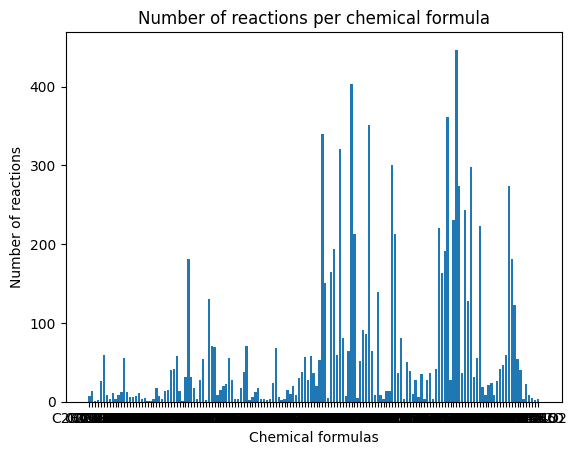

In [116]:
# Plot distribution of reactions per chemical formula
print(f'Total number of chemical formulas {len(counts_reactant.keys())}')
print(f'Total number of reactions {sum(counts_reactant.values())}')
fig, ax = plt.subplots()
ax.set_title('Number of reactions per chemical formula')
ax.bar(counts_reactant.keys(), counts_reactant.values())
ax.set_xlabel('Chemical formulas')
ax.set_ylabel('Number of reactions')
plt.show()

In [117]:
# Print molecular configuration dictionary, that is returned by the dataloader.
dataloader = Dataloader('data/transition1x.h5')
molecule = next(iter(dataloader))
print(f"Data type: {type(molecule)}")

print("Molecule No 1")
print("=========")
print(f"Chemical formula: {molecule['formula']}")
print(f"Reaction molecule is coming from: {molecule['rxn']}")
print(f"Atom positions/XYZ coords: \n {molecule['positions']}")
print(f"Atomic numbers, ordered in same way as the positions: {molecule['atomic_numbers']}")
print(f"Total energy in eV: {molecule['wB97x_6-31G(d).energy']}")
print(f"Atomization energy in eV: {molecule['wB97x_6-31G(d).atomization_energy']}")
print(f"Forces on each atom in eV/Å: \n {molecule['wB97x_6-31G(d).forces']}")

Data type: <class 'dict'>
Molecule No 1
Chemical formula: C2H2N2O
Reaction molecule is coming from: rxn2091
Atom positions/XYZ coords: 
 [[ 0.06342524 -0.92886364  0.22975714]
 [ 1.0350014  -0.0944876  -0.20364845]
 [ 0.60982314  1.09196961 -0.45709223]
 [-0.75354943  1.0752695  -0.18144211]
 [-1.01893935 -0.11949062  0.21207341]
 [ 2.0347672  -0.4913263  -0.30018865]
 [-1.97025537 -0.53321665  0.51340628]]
Atomic numbers, ordered in same way as the positions: [8, 6, 7, 7, 6, 1, 1]
Total energy in eV: -7130.09805147626
Atomization energy in eV: -32.44572913700813
Forces on each atom in eV/Å: 
 [[-0.014290707539290617, 0.020040185772169136, -0.026752898103443237], [-0.01700248346596246, -0.04152885362979994, 0.0008951769926013323], [0.017973394519020178, -0.006697023972825467, -0.007404254184386231], [-0.002013988092180561, -0.0035097810504688253, 0.0057402677179095385], [-0.007755575094643374, -0.011449979363690506, 0.00321411902567595], [-0.0019918912071987083, 0.030121060210041527, 0

In [118]:
# Visualize ase atom object 
atoms = io.read("data/rxn0001/p.xyz")
view(atoms, viewer='x3d')

In [122]:
# Load the toluene npz file from the NequIP tutorial as a template on how to create a Transition1x npz file
data = np.load('benchmark_data/toluene_ccsd_t-train.npz')
# Print the variables/key from the NPZ file. Each key has associated with it a data array. 
# The toluene dataset contains following keys: ['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']
print(data.files)

def create_npz(dataloader, split):
    """Extract the data from the dataloader object and convert it to a numpy array
    """
    states = ['reactant', 'product', 'transition_state']
    for state in states:
        R_array = np.concatenate([configurations[state]['positions'] for configurations in dataloader])
        z_array = np.concatenate([configurations[state]['atomic_numbers'] for configurations in dataloader])
        E_array = np.concatenate([np.array(configurations[state]['wB97x_6-31G(d).energy']).flatten() for configurations in dataloader])
        F_array = np.concatenate([configurations[state]['wB97x_6-31G(d).forces'] for configurations in dataloader])
        name_array = np.concatenate([np.array(configurations[state]['rxn']).flatten() for configurations in dataloader])

        # Create directory to save xyz files
        rxn_path = os.path.join('data', split)
        os.makedirs(rxn_path, exist_ok=True)

        # Save it to an NPZ file
        my_dict = {"z": z_array, "R": R_array, "F": F_array, "E": E_array, "name": name_array}
        np.savez(f"data/{split}/{state}_{split}.npz", **my_dict)

create_npz(dataloader_train, split='train')

['E', 'name', 'F', 'theory', 'R', 'z', 'type', 'md5']


In [130]:
# Check npz export
data = np.load('data/train/reactant_train.npz')
data['name']

array(['rxn3534', 'rxn3535', 'rxn3536', ..., 'rxn1913', 'rxn2322',
       'rxn2323'], dtype='<U8')